In [ ]:
import pandas as pd
import re
import os
import numpy as np
import nltk
import spacy
import string
import matplotlib.pyplot as plt
from nltk import word_tokenize
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

nlp = spacy.load("en_core_web_sm")
nltk.download('universal_tagset')
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\sirau\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sirau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Я решил работать с датасетами диалогов в надежде, что они дадут информацию о структурах сообщений-планов. 
Нам надо из сообщений, где есть даты\вермя выделить именно те, которые говорят о плане задаче или о событии. Вероятнее всего надо попробовать прокластеризировать сообщения, так как вручную разметить десятки тысяч сообщений не вариант. Когда будет размеченный датасет, можно попробовать построить классификатор)

Сначала сделаем алгоритм, который ищет токен времени и соотносящийся к нему ROOT токен с помощью spacy. Строка из датасета multiwoz.ipynb

In [ ]:
docs = ["Boss is planning a vacation tomorrow night and really could use some help finding a good place to stay in town.",
        "I`m going to stay here 2 for 5 nights starting Sunday",
        "I need to arrive at 13:45",
        "I need the travel day to be Sunday",
        "I'll be going to Cambridge and arrive by 13:45", 
        "Train TR7468 will arrive at 13:23.",
        "Bears wake up at spring"]

In [ ]:
tags = []
doc = nlp(docs[0])
for token in doc:
    tags.append([token.text, token.lemma_, token.ent_type_, token.pos_, token.tag_, token.dep_, token.head])
postok = {str(i): list(doc).index(i) for i in doc}
pd.DataFrame(tags, columns = ["Token", "lemma", "entity", "full", "entity", "dep type", "head"])

,Token,lemma,entity,full,entity,dep type,head
0,Boss,boss,,NOUN,NN,nsubj,planning
1,is,be,,AUX,VBZ,aux,planning
2,planning,plan,,VERB,VBG,ROOT,planning
3,a,a,,DET,DT,det,vacation
4,vacation,vacation,,NOUN,NN,dobj,planning
5,tomorrow,tomorrow,,NOUN,NN,compound,night
6,night,night,,NOUN,NN,npadvmod,planning
7,and,and,,CCONJ,CC,cc,planning
8,really,really,,ADV,RB,advmod,use
9,could,could,,AUX,MD,aux,use


In [ ]:
displacy.render(doc, jupyter=True)

Я хочу развернуть полное предложение - ивент, от времени до главного слова фразы

In [ ]:
tok = doc[postok["tomorrow"]] #Time token
tok_seq = []
token_head = tok
while True:
    filtered_tok_seq = [] # filter extra dependencies of root word
    head_tok_seq = [*[i for i in token_head.lefts if i not in tok_seq], token_head, *[i for i in token_head.rights if i not in tok_seq]]
    for j in range(len(head_tok_seq)):
        if (head_tok_seq[j].dep_ in ["dobj", "nsubj", "ROOT"]) or (head_tok_seq[j] is token_head):
            filtered_tok_seq.append(head_tok_seq[j])
    tok_seq.extend(filtered_tok_seq)
    if (token_head.dep_ == "ROOT"):
        break
    token_head = token_head.head
tok_seq

[tomorrow, night, Boss, planning, vacation]

Получили из токена времени tomorrow полное предложение - Boss, planning, vacation, tomorrow, night

## Representatoins of messages
 В начале посмотрим на датасет с сообщениями, собранный из источников:

In [216]:
df = pd.DataFrame()
for frame in os.listdir("../processed_data"):
    df_temp = pd.read_csv(f"../processed_data/{frame}", index_col=0)
    df = pd.concat([df, df_temp])
    del df_temp
df = df.iloc[:, :-1]
df.to_csv("../processed_data/data.csv")
df.head()

,text,root,event
0,Are you a fan of Google or Microsoft ?,NaN,NaN
1,Both are excellent technology they are helpful...,NaN,NaN
2,"I 'm not a huge fan of Google , but I use it...",NaN,NaN
3,Google provides online related services and pr...,NaN,NaN
4,"Yeah , their services are good . I 'm just not...",NaN,NaN


In [217]:
print(f"{df.shape[0]} - количество записей в датасете")

2001000 - количество записей в датасете


In [218]:
print(f'{df[~df["root"].isna()].shape[0]} - количество записей с указателями даты или времени')

278232 - количество записей с указателями даты или времени


Получили из 4 источников 1798937 сообщений и 171740 собщений с датами. Можем продолжать с этим работать

### Preprocessing and TfIdf


In [219]:
def prepare_text(input: str) -> list:
  output = re.sub(r"\S*@\S*\s?", "", input) #emails
  output = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', output) # any URL
  output = re.sub(r'[.,!()?:<>#]{2,}', '', output) # repeated punctuations
  output = re.sub(r'\s{2,}', ' ', output) # repeated spaces
  doc = nlp(output)
  output = [tag.lemma_ for tag in doc]
  return output

prepare_text("He wants to go on Nevsky prospect at 7 o`clock today")

['he',
 'want',
 'to',
 'go',
 'on',
 'Nevsky',
 'prospect',
 'at',
 '7',
 'o`clock',
 'today']

In [220]:
eng_stopwords = stopwords.words('english')
punct = string.punctuation
def stopwords_delete(input: list) -> list:
  output = [token for token in input if token not in eng_stopwords]
  output = [token for token in output if token not in punct]
  return output
stopwords_delete(prepare_text("He wants to go on Nevsky prospect at 7 o`clock today"))

['want', 'go', 'Nevsky', 'prospect', '7', 'o`clock', 'today']

### Try mannualy extract sentences with words

In [221]:
ttt  = df[~df["root"].isna()]
ttt[ttt["text"].str.contains("plan")]

,text,root,event
296,"Yes , that is sad in some ways too . Happy we ...",keeping,them today we is keeping
1288,There is a planet where shards of glass rain s...,is,at in planet sideways degree mph shards 4500 w...
1420,wow ! I love learning ! I think I saw once tha...,think,I saw planet astronomers years think found man...
1587,I prefer the original 3 from my childhood in t...,prefer,in 3 prefer 70 I
2412,"The 50 's were a different time , unfortunatel...",thought,ago thought 1800 years
...,...,...,...
230063,I am the opposite . I do not like Summer . ...,is,"meet is years needs 500,000 you fact for"
230108,"Yes , I do and think its a great idea ! The su...",produces,one meet years sun energy second for in produc...
230214,Are you planning to watch the next fifa world ...,planning,planning 2022 you watch in cup
230483,"Yeah , that was premeditated and I 'm sure rac...",getting,getting lunch ready I today plan


<AxesSubplot: >

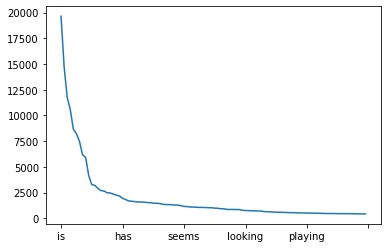

In [222]:
df[~df["root"].isna()]["root"].value_counts()[:100].plot()

In [223]:
df[~df["root"].isna()]["root"].value_counts()

is             19648
know           14751
was            11770
have           10570
be              8666
               ...  
sharing            2
8962105            2
telephone          2
appropriate        2
8902365            2
Name: root, Length: 3863, dtype: int64

### Preprocess and BoW

In [225]:
from collections import Counter
counter_words = Counter()

def pipeline(input):
  output = prepare_text(input)
  output = stopwords_delete(output)
  for word in output:
    counter_words[word] += 1         # collect frequencies
  return output

df_part = df[~df["root"].isna()].iloc[:1000, :]
df_part["message_processed"] = df_part["text"].apply(pipeline)
df_part.head()

,text,root,event,message_processed
7,"It is very interesting . Google provide "" Chro...",provided,2015 Google lot to 2010 provided in,"[interesting, Google, provide, Chrome, OS, lig..."
23,Yes he even won a hardcore cha cha championshi...,won,won 1958 in championship he,"[yes, even, win, hardcore, cha, cha, champions..."
26,Yeah . Ballet dancer go through 4 pairs of sho...,go,through week pairs go a dancer 4,"[yeah, ballet, dancer, go, 4, pair, shoe, week]"
42,Hey what 's up do use Google very often?I real...,use,Google surprised company founded use 1998 was ...,"[hey, use, Google, often?i, really, love, comp..."
43,i think everyone must use it daily ! its becom...,become,day ingrained become every in life,"[I, think, everyone, must, use, daily, become,..."


Посмотрим на распределения частот слов 

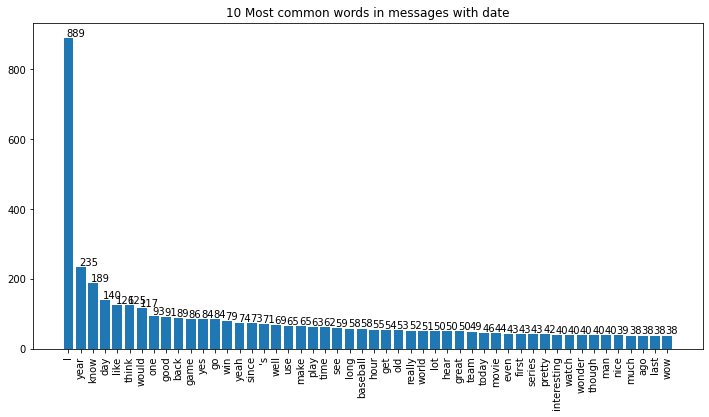

In [226]:
data = counter_words.most_common(50)
x = [x[0] for x in data]
y = [l[1] for l in data]
plt.figure(figsize=(12, 6))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title("10 Most common words in messages with date")
for i in range(len(x)):
  plt.text(i-0.15,y[i]+5,y[i])

<AxesSubplot: >

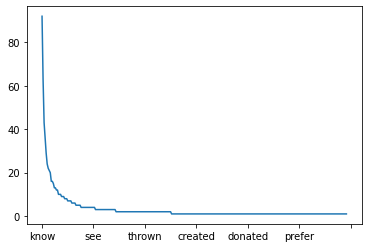

In [230]:
df_part["root"].value_counts().plot()

Намечается явная проблема - датасет на одну тему получился - о спорте. Но какие то указатели, типа minute year day would time last уже есть в топе слов, что довольно отрадно. Постараемся еще проанализировать датасет - отвекторизуем его и посмотрим отображение с помощью t-SNE. Используем Bag of Words

In [ ]:
model_bow = CountVectorizer()
X = model_bow.fit_transform(df_part["message_processed"].apply(lambda x: " ".join(x))).toarray()

In [ ]:
X.shape

(1000, 2986)

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 't-SNE representation of dataset')

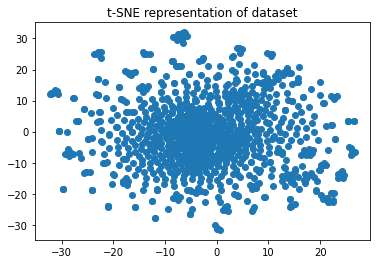

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
data = tsne.fit_transform(X)
plt.scatter(x=data[:, 0], y=data[:, 1])
plt.title("t-SNE representation of dataset")

## Word2vec

In [ ]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
import gensim.downloader
model = Word2Vec(common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [ ]:
glove_vectors = gensim.downloader.load('glove-twitter-25')

In [ ]:
glove_vectors.get_vector("plan")

array([ 0.47415 ,  0.93673 , -0.62139 , -0.013054,  0.98956 ,  0.45873 ,
       -0.02254 ,  0.6956  ,  0.44207 , -0.44703 ,  0.33811 , -0.92783 ,
       -3.6716  ,  0.84413 ,  1.1669  ,  0.50926 ,  0.73615 ,  0.10636 ,
       -0.24516 , -1.0525  ,  0.44059 , -0.86163 , -0.39066 , -0.075361,
        0.029276], dtype=float32)

In [ ]:
glove_vectors.most_similar("plan", )

[('media', 0.8908759951591492),
 ('personal', 0.8748670816421509),
 ('control', 0.8535847663879395),
 ('idea', 0.8530606031417847),
 ('general', 0.852401614189148),
 ('debate', 0.8438900709152222),
 ('social', 0.842548131942749),
 ('sales', 0.8322349190711975),
 ('service', 0.8312507271766663),
 ('resume', 0.8249419927597046)]

### Russian hand made dataset

In [232]:
df_manual = []
with open("../edz_dataset_eng.txt", "r", encoding="utf-8") as f:
    for line in f:
        df_manual.append(line[:-1])


In [233]:
tags = []
doc = nlp(df_manual[0])
for token in doc:
    tags.append([token.text, token.lemma_, token.ent_type_, token.pos_, token.tag_, token.dep_, token.head])
postok = {str(i): list(doc).index(i) for i in doc}
pd.DataFrame(tags, columns = ["Token", "lemma", "entity", "full", "entity", "dep type", "head"])

,Token,lemma,entity,full,entity,dep type,head
0,Tomorrow,tomorrow,DATE,NOUN,NN,npadvmod,go
1,I,I,,PRON,PRP,nsubj,go
2,'ll,will,,AUX,MD,aux,go
3,go,go,,VERB,VB,ROOT,go
4,to,to,,ADP,IN,prep,go
5,work,work,,VERB,VB,pobj,to
6,at,at,,ADP,IN,prep,work
7,morning,morning,TIME,NOUN,NN,pobj,at


In [234]:
model_bow = CountVectorizer()
X = model_bow.fit_transform(df_manual).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [235]:
df_part["message_processed"].apply(lambda x: " ".join(x)).shape

(1000,)

In [236]:
np.array(df_manual)[:10]

array(["Tomorrow I'll go to work at morning",
       'the day after tomorrow we plan to go to the country',
       "by the evening I'm planning to finish the report",
       'Sunday afternoon we will go to a restaurant',
       'by 20 p.m. I will finish the project',
       'at 06:30 we get up for a warm-up',
       'On April 28, a race will take place on the square',
       'on thursday we will go camping with friends',
       'from 9 am to 8 pm I will write a diploma',
       'we will drive all evening tomorrow by car along the highway'],
      dtype='<U76')

In [ ]:
print(f"{len(df_manual)} записей напсианы вручную")

37 записей напсианы вручную


In [237]:
counter_words_manual = Counter()
def pipeline(input):
  output = prepare_text(input)
  output = stopwords_delete(output)
  for word in output:
    counter_words_manual[word] += 1         # collect frequencies
  return output
df_manual = [pipeline(i) for i in df_manual]

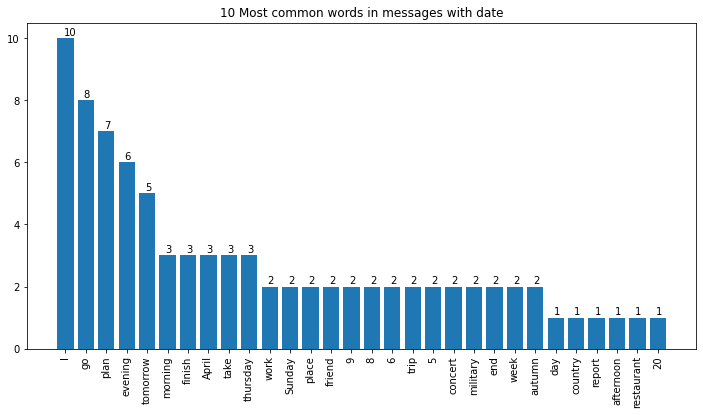

In [238]:
data = counter_words_manual.most_common(30)
x = [x[0] for x in data]
y = [l[1] for l in data]
plt.figure(figsize=(12, 6))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title("10 Most common words in messages with date")
for i in range(len(x)):
  plt.text(i-0.1,y[i]+0.1,y[i])

In [241]:
df_manual = [" ".join(i) for i in df_manual]

In [242]:
model_bow = CountVectorizer()
texts_corpus = df_part["message_processed"].apply(lambda x: " ".join(x))
texts_corpus = np.concatenate([texts_corpus, np.array(df_manual)])
X = model_bow.fit_transform(texts_corpus).toarray()

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 't-SNE representation of dataset')

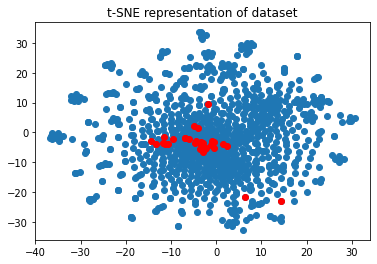

In [244]:
tsne = TSNE()
data = tsne.fit_transform(X)
plt.scatter(x=data[:, 0], y=data[:, 1])
plt.scatter(x=data[-30:, 0], y=data[-30:, 1], color="red")
plt.title("t-SNE representation of dataset")

In [245]:
texts_corpus[np.argwhere(np.logical_and(data[:, 0]>0, data[:, 1]>0)).squeeze()]

array(['yes sure grow much year',
       'cool cat pretty smart specie cat specie extinction 10,000 year',
       'I could say well lol odd meeting two couple month ago',
       'I think rap major significance last twenty year though huh',
       'yeah snl skit mocking interrupting award show 2 year infamous Taylor Swift incident',
       'yes Senate big tradition use gavel 165 year got crack',
       'I think might nobody vote Voter turn go high 62 100 year',
       'I think I would bad Richard Nixon crack 165 year old gavel senate use must somewhere display',
       'voter turnout presidential election breach 62.8 last 100 year actually I would guess',
       'well see voting twenty year make easy number probably rise',
       'yes I even though go forest full lion voter turnout US presidential election reach 62.8 percent last 100 year',
       '2005 married couple schedule 2430 major league baseball game play year 24 year I bet could get confusing',
       'almost 100 year old Mouse

In [252]:
y_train =np.array([0 for i in range(63)]+[1 for i in range(37)])
x_train = X[-100:]

In [253]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train)

In [255]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [269]:
model.score(x_test, y_test)

0.92

In [268]:
xr = model_bow.transform(["suck "]).toarray()
model.predict(xr)

array([1])